In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from src.data_loading import DlDataset
from src.convnet import train_net

import matplotlib.pyplot as plt

In [3]:
# Not very elegant but removes all the warnings about deprecated upsample funtion
import warnings
warnings.filterwarnings("ignore")

In [4]:
#import data for a 1000 pairs
N = 1000
dataset_train = DlDataset(N, normalize=True, upsample=(28,28))
dataset_test = DlDataset(N, normalize=True, upsample=(28,28))
dataset_train.train()
dataset_test.test()

In [5]:
#model, simple cnn with 2 conv layers and one hidden and output layer
#Number of parameters 224290
class Net(nn.Module):
    def __init__(self,hiddenUnits):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64*5*5, hiddenUnits)
        self.fc2 = nn.Linear(hiddenUnits, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.drop1 = nn.Dropout2d(p=0.25)
        self.drop2 = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        #x = self.drop1(x)
        x = self.bn2(x)        
        x = F.relu(self.fc1(x.view(-1, 64*5*5)))
        #x = self.drop2(x)
        #x = self.fc2(x)
        x = F.log_softmax(self.fc2(x),dim=1)
        return x

In [6]:
# Train parameter
epochs = 15
eta = 5e-3
lambda_l2 = 1e-3
gamma = 0.2
depth = 4
n_filters = 3

# U-Net definition
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu') #Hannes' gpu is not supported but has cuda cores... 
model = Net(128).to(device)
optim = torch.optim.SGD(model.parameters(), lr=eta, momentum=gamma)
criterion = torch.nn.CrossEntropyLoss()
dataloader = []
dataloader.append(DataLoader(dataset_train, batch_size=10,shuffle=True, num_workers=4))
dataloader.append(DataLoader(dataset_test, batch_size=10,shuffle=True, num_workers=4))

avg_loss_train,avg_acc_train,avg_loss_test,avg_acc_test, model = train_net(model, device, optim, criterion, dataloader,
                                                     epochs=epochs, lambda_=1e-3, reg_type=None, 
                                                     save=False)

Epoch 0: Train Loss: 0.06, Train Acc: 0.69, Val Loss: 0.05, Val Acc: 0.75
Epoch 1: Train Loss: 0.05, Train Acc: 0.78, Val Loss: 0.05, Val Acc: 0.75
Epoch 2: Train Loss: 0.04, Train Acc: 0.79, Val Loss: 0.05, Val Acc: 0.78
Epoch 3: Train Loss: 0.04, Train Acc: 0.83, Val Loss: 0.04, Val Acc: 0.80
Epoch 4: Train Loss: 0.03, Train Acc: 0.85, Val Loss: 0.04, Val Acc: 0.80
Epoch 5: Train Loss: 0.03, Train Acc: 0.88, Val Loss: 0.04, Val Acc: 0.81
Epoch 6: Train Loss: 0.03, Train Acc: 0.90, Val Loss: 0.04, Val Acc: 0.83
Epoch 7: Train Loss: 0.02, Train Acc: 0.92, Val Loss: 0.05, Val Acc: 0.80
Epoch 8: Train Loss: 0.02, Train Acc: 0.93, Val Loss: 0.04, Val Acc: 0.82
Epoch 9: Train Loss: 0.02, Train Acc: 0.94, Val Loss: 0.04, Val Acc: 0.83
Epoch 10: Train Loss: 0.02, Train Acc: 0.95, Val Loss: 0.04, Val Acc: 0.82
Epoch 11: Train Loss: 0.02, Train Acc: 0.96, Val Loss: 0.04, Val Acc: 0.83
Epoch 12: Train Loss: 0.01, Train Acc: 0.97, Val Loss: 0.04, Val Acc: 0.82
Epoch 13: Train Loss: 0.01, Train A

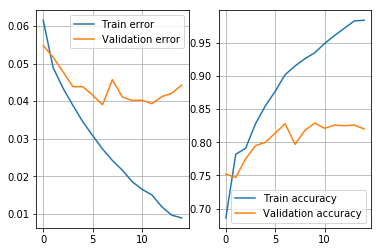

In [7]:
plt.figure('History Plot')
plt.title('Error and Accuracy of Network')
plt.subplot(1,2,1)
plt.plot(range(0,epochs), avg_loss_train, label = 'Train error')
plt.plot(range(0,epochs), avg_loss_test, label = 'Validation error')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(0,epochs), avg_acc_train, label = 'Train accuracy')
plt.plot(range(0,epochs), avg_acc_test, label = 'Validation accuracy')
plt.grid()
plt.legend();

Predicted Target: 1, Real Target: 1
Real classes are, left: 1 right: 2
Predicted Target: 0, Real Target: 0
Real classes are, left: 7 right: 1


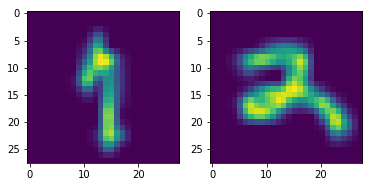

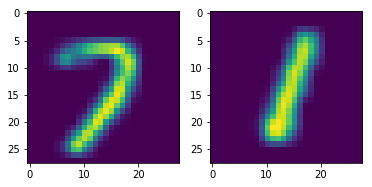

In [8]:
dataset_test.infere(model,5);
dataset_test.infere(model,6);